# Import Python packages

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Get all the excel data files in the directory/folder

In [287]:
import glob
files = list(glob.glob('*.xlsx'))
len(files)

131

## Read in the first file

In [368]:
x = pd.read_excel(files[0],skiprows=1, usecols='A:C')
x = x.loc[~x['Sample'].str.startswith('S0'),:]
x[['Sample','CellType','DrugName','Dosage']] = (x['Sample'].str.split(",", expand=True)).iloc[:,0:4]
x = x[['Sample','CellType','DrugName','Dosage','Assay','Calc. Concentration']]
x.Dosage = x.Dosage.str.replace(' ng/mL','')
x.rename(columns={'Dosage': 'Dosage (ng/mL)'},inplace=True)

In [369]:
x['DrugName'].unique()

array([' DK1210', ' DK210E', ' DK710E', ' DKIFNa10'], dtype=object)

## Read in the rest of the files and append each to the existing data table

In [370]:
data_list = [x]

for file in files[1:]:
    temp = pd.read_excel(file, skiprows=1)
    temp = temp.loc[~temp['Sample'].str.startswith('S0'),:]
    temp['Sample'] = temp['Sample'].str.replace(', Rep 2','_Rep 2')
    temp['Sample'] = temp['Sample'].str.replace(', 1210',', DK1210')
    temp['Sample'] = temp['Sample'].str.replace(', 210E',', DK210E')
    temp['Sample'] = temp['Sample'].str.replace(', DK210,',', DK210E,')
    temp['Sample'] = temp['Sample'].str.replace(', 710E',', DK710E')
    temp['Sample'] = temp['Sample'].str.replace(', IFNa10',', DKIFNa10')
    temp[['Sample','CellType','DrugName','Dosage']] = (temp['Sample'].str.split(",", expand=True)).iloc[:,0:4]
    temp = temp[['Sample','CellType','DrugName','Dosage','Assay','Calc. Concentration']]
    temp['Dosage']
    temp.Dosage = temp.Dosage.str.replace(' ng/mL','')
    temp.rename(columns={'Dosage': 'Dosage (ng/mL)'},inplace=True)
    data_list.append(temp)

x = pd.concat(data_list)

In [371]:
x.shape

(81104, 6)

In [372]:
x.columns

Index(['Sample', 'CellType', 'DrugName', 'Dosage (ng/mL)', 'Assay',
       'Calc. Concentration'],
      dtype='object')

In [373]:
x.head(10)

,Sample,CellType,DrugName,Dosage (ng/mL),Assay,Calc. Concentration
0,HMN1080358,CD8,DK1210,0,GM-CSF,3.482720
1,HMN1080358,CD8,DK1210,0,GM-CSF,5.231975
2,HMN1080358,CD8,DK1210,2,GM-CSF,18.084781
3,HMN1080358,CD8,DK1210,2,GM-CSF,20.485659
4,HMN1080358,CD8,DK1210,20,GM-CSF,13.090651
5,HMN1080358,CD8,DK1210,20,GM-CSF,17.558496
6,HMN1080358,CD8,DK1210,200,GM-CSF,13.012524
7,HMN1080358,CD8,DK1210,200,GM-CSF,13.038565
8,HMN1080358,CD8,DK210E,0,GM-CSF,4.157858
9,HMN1080358,CD8,DK210E,0,GM-CSF,4.534543


In [374]:
x['DrugName'].value_counts()

 DK210E      33834
 DK710E      21518
 DK1210      20668
 DKIFNa10     4492
 DK1510E       552
Name: DrugName, dtype: int64

In [375]:
x = x[(x['Dosage (ng/mL)'] !=' 0.02') & (x['Dosage (ng/mL)'] !=' 0.2')]

In [376]:
x_table = x.groupby(['DrugName', 'Assay','Sample','Dosage (ng/mL)'])['Calc. Concentration'].aggregate(['mean', 'std']).unstack()

In [378]:
pd.set_option('display.max_rows', 7500)

In [379]:
idx = pd.IndexSlice

In [390]:
ratio_20_0 = x_table.loc[idx[' DK210E','IFN-γ',:],idx['mean',[' 20']]].droplevel(0,axis=1)[' 20'] / x_table.loc[idx[' DK210E','IFN-γ',:],idx['mean',[' 0']]].droplevel(0,axis=1)[' 0']

In [391]:
ratio_20_0.quantile(q=np.linspace(0,1,5))

0.00         0.406345
0.25         5.735809
0.50        14.433151
0.75        32.881054
1.00    948170.576849
dtype: float64

In [392]:
ratio_20_0.shape

(287,)

In [393]:
ratio_20_0 = ratio_20_0[(ratio_20_0 > 14.433151 - 5 * (32.881054 - 5.735809)) & (ratio_20_0 < 14.433151 + 5 * (32.881054 - 5.735809)) ]

In [395]:
ratio_20_0.shape

(269,)

<Axes: ylabel='Density'>

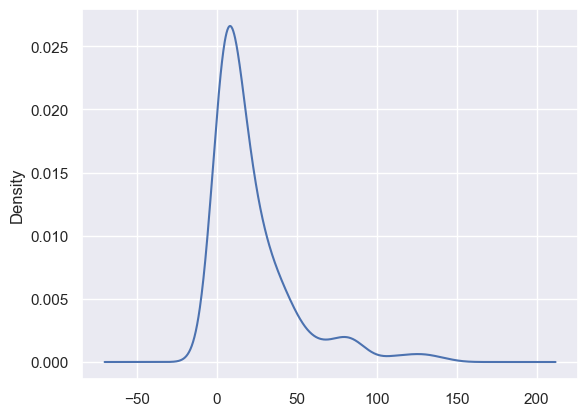

In [399]:
ratio_20_0.plot(kind="kde")

In [322]:
x_table.loc[idx[' DK210E','IFN-γ',:],idx['mean',:]].quantile(q=np.linspace(0,1,5))

mean                              \
DrugConcentration (ng/mL)            0             2            20   
0.00                          0.028190     56.782309     54.182463   
0.25                        233.533629   1408.784026   4855.242556   
0.50                        580.401252   2722.225882  10143.674382   
0.75                       1405.606334   5350.834864  18313.046352   
1.00                       8830.095935  21301.739383  72911.668689   

                                          
DrugConcentration (ng/mL)            200  
0.00                           63.789983  
0.25                         5542.855366  
0.50                        13412.749363  
0.75                        24892.310798  
1.00                       108378.355102

In [358]:
ratio_20_0.head()

DrugName  Assay  Sample    
 DK210E   IFN-γ  HMN1069640        14.433151
                 HMN1069641              NaN
                 HMN1069642    948170.576849
                 HMN1074554        17.964052
                 HMN1074555         8.993662
dtype: float64

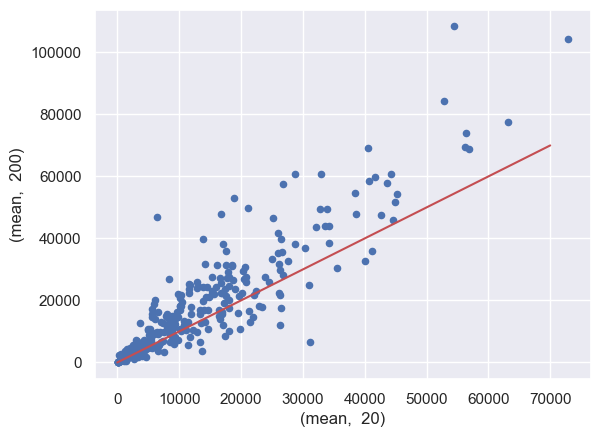

In [401]:
x_table.loc[idx[' DK210E', 'IFN-γ',:],idx['mean', [' 20', ' 200']]].plot(kind='scatter', x=('mean', ' 20'), y=('mean', ' 200'));
plt.plot([0,70000], [0,70000],color='r',linestyle='-');

In [474]:
thresholds = 0.75 * x_table.loc[idx[' DK210E', 'IFN-γ', :],idx['mean',[' 200']]].droplevel(0,axis=1)[' 200'] + 0.25 * x_table.loc[idx[' DK210E', 'IFN-γ', :],idx['mean',[' 20']]].droplevel(0,axis=1)[' 20']

In [475]:
thresholds.shape

(287,)

In [476]:
high = np.sum(thresholds>12000)/ thresholds.shape[0]
print(f'{high: .2f}')
low = np.sum(thresholds<3000)/ thresholds.shape[0]
print(f'{low: .2f}')

 0.54
 0.13


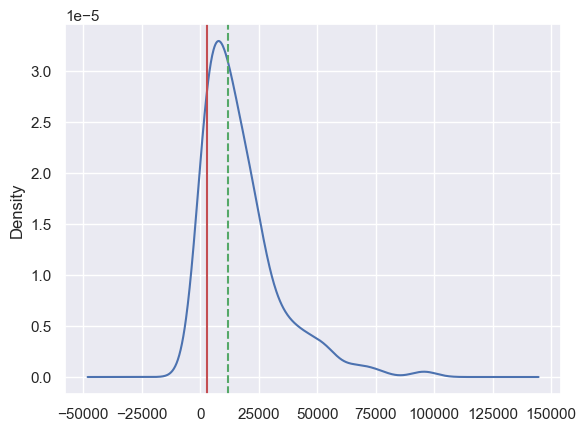

In [488]:
thresholds.plot(kind="kde")
plt.axvline(x=12000, color='g', linestyle='--')
plt.axvline(x=3000, color='r', );

In [484]:
x_table.loc[idx[' DK210E', 'IFN-γ', :],idx['mean', :]].droplevel(0,axis=1).to_csv("sample_DK210_IFNg.txt",sep="\t")

In [324]:
x_table.loc[idx[' DK210E', 'IFN-γ', :],idx['mean', :]].corr()

mean                              
DrugConcentration (ng/mL)              0         2        20       200
     DrugConcentration (ng/mL)                                        
mean  0                         1.000000  0.725478  0.229041  0.245594
      2                         0.725478  1.000000  0.597000  0.552074
      20                        0.229041  0.597000  1.000000  0.898416
      200                       0.245594  0.552074  0.898416  1.000000

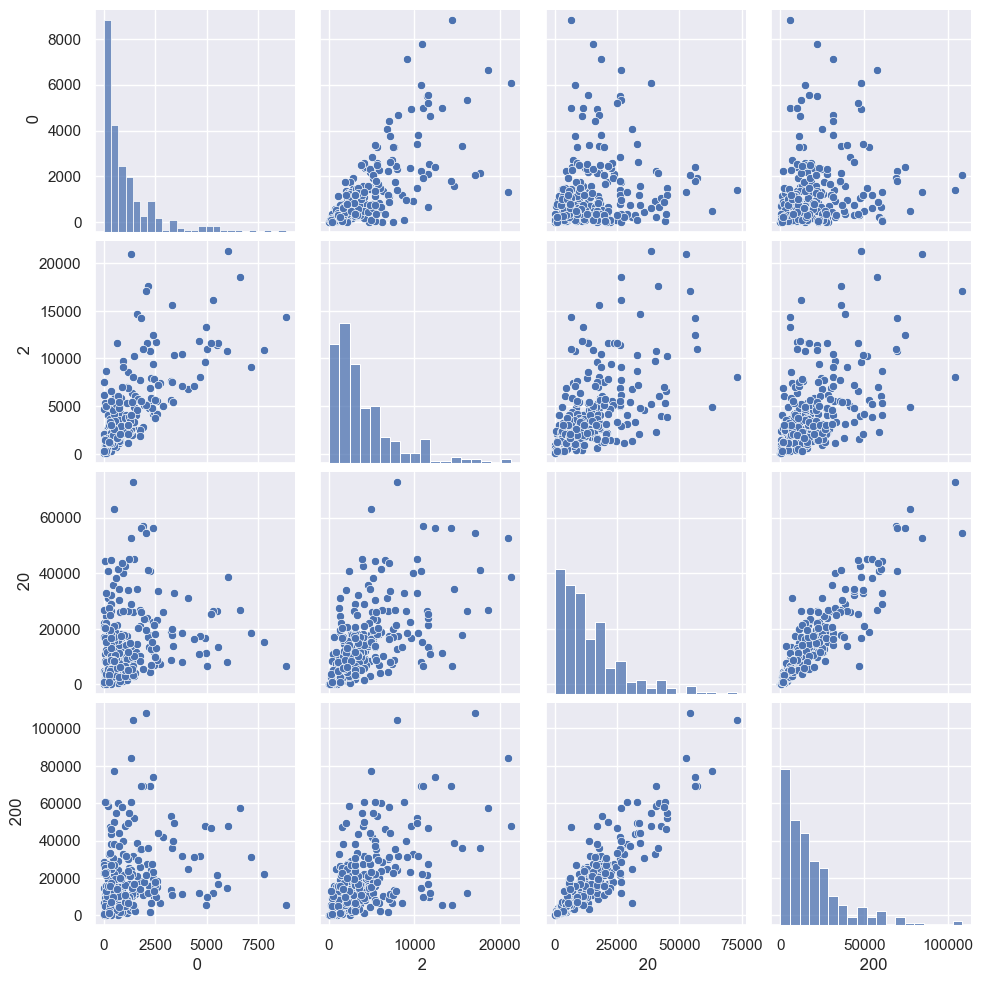

In [325]:
sns.pairplot(x_table.loc[idx[' DK210E', 'IFN-γ',:],idx['mean',:]].droplevel(0,axis=1))

In [454]:
from collections import Counter
idxs = []
for idx in x_table.index:
    idxs.append(idx[1])

print(Counter(idxs))

Counter({'Granzyme B': 761, 'IFN-γ': 761, 'TNF-α': 761, 'TIGIT': 707, 'GM-CSF': 631, 'Granzyme A': 538, 'IL-2': 506, 'Perforin': 452, 'PD-1 (epi 1)': 447, 'IL-4': 391, 'PD-1': 261, 'Tim-3': 253, 'IL-6': 251, 'IL-12p70': 140, 'LAG3': 111, 'VISTA': 80, 'IL-1β': 78, 'IFN-α2a': 28, 'PD-1 (Epi1)': 2, 'TIM3': 2})


In [457]:
idx = pd.IndexSlice

In [458]:
thresholds = 0.75 * x_table.loc[idx[' DK710E', 'IFN-γ', :],idx['mean',[' 200']]].droplevel(0,axis=1)[' 200'] + 0.25 * x_table.loc[idx[' DK710E', 'IFN-γ', :],idx['mean',[' 20']]].droplevel(0,axis=1)[' 20']

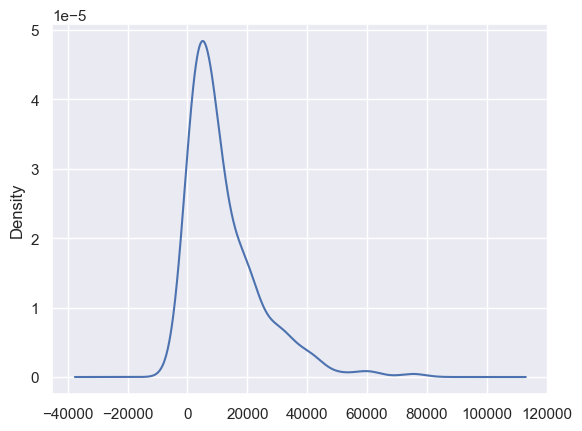

In [460]:
thresholds.plot(kind='kde');

In [462]:
import statsmodels.api as sm

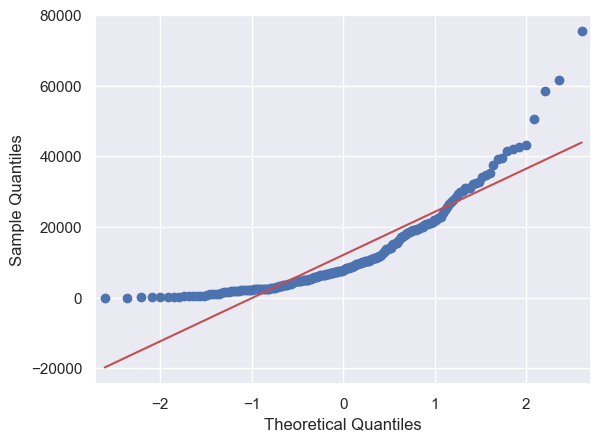

In [469]:
sm.qqplot(thresholds, line='s');